In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm

from categorical import one_hot_encode_categorical
from feature_nlp import nlp
from feature_numerical import process_numerical_columns
from location_preprocessing import get_locations_features
from feature_date import cyclical_encode_dates
from parse_amenities import parse_amenities

In [371]:
df = pd.read_csv("Airbnb_Data.csv")
print(df.shape)
df.head()

(74111, 29)


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [372]:
df.set_index('id', inplace=True)
df.head()

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
id,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [502]:
df_amenities_count = parse_amenities(df)
print(df_amenities_count.shape)
df_amenities_count.head()

(74111, 1)


,amenities_count
id,
6901257,-1.242623
6304928,-0.375379
7919400,0.202783
13418779,-0.375379
3808709,-0.809001


In [228]:
df_categorical = one_hot_encode_categorical(df)
print(df_categorical.shape)
df_categorical.head()

/Users/ChanWingYiu/Documents/Data Science in the Wild/Project/dsw-project/categorical.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical_group].fillna("Unknown", inplace=True)


(74111, 58)


,one_hot_encoder__property_type_Apartment,one_hot_encoder__property_type_Bed & Breakfast,one_hot_encoder__property_type_Boat,one_hot_encoder__property_type_Boutique hotel,one_hot_encoder__property_type_Bungalow,one_hot_encoder__property_type_Cabin,one_hot_encoder__property_type_Camper/RV,one_hot_encoder__property_type_Casa particular,one_hot_encoder__property_type_Castle,one_hot_encoder__property_type_Cave,...,one_hot_encoder__cleaning_fee_False,one_hot_encoder__cleaning_fee_True,one_hot_encoder__host_has_profile_pic_f,one_hot_encoder__host_has_profile_pic_t,one_hot_encoder__host_has_profile_pic_nan,one_hot_encoder__host_identity_verified_f,one_hot_encoder__host_identity_verified_t,one_hot_encoder__host_identity_verified_nan,one_hot_encoder__instant_bookable_f,one_hot_encoder__instant_bookable_t
id,,,,,,,,,,,,,,,,,,,,,
6901257,True,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,True,False,True,False
6304928,True,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,False,False,False,True
7919400,True,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,True
13418779,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,True,False,True,False
3808709,True,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,True


In [230]:
df_categorical.columns

Index(['one_hot_encoder__property_type_Apartment',
       'one_hot_encoder__property_type_Bed & Breakfast',
       'one_hot_encoder__property_type_Boat',
       'one_hot_encoder__property_type_Boutique hotel',
       'one_hot_encoder__property_type_Bungalow',
       'one_hot_encoder__property_type_Cabin',
       'one_hot_encoder__property_type_Camper/RV',
       'one_hot_encoder__property_type_Casa particular',
       'one_hot_encoder__property_type_Castle',
       'one_hot_encoder__property_type_Cave',
       'one_hot_encoder__property_type_Chalet',
       'one_hot_encoder__property_type_Condominium',
       'one_hot_encoder__property_type_Dorm',
       'one_hot_encoder__property_type_Earth House',
       'one_hot_encoder__property_type_Guest suite',
       'one_hot_encoder__property_type_Guesthouse',
       'one_hot_encoder__property_type_Hostel',
       'one_hot_encoder__property_type_House',
       'one_hot_encoder__property_type_Hut',
       'one_hot_encoder__property_type_In-law'

In [231]:
df_nlp = nlp(df)
print(df_nlp.shape)
df_nlp.head()

(74111, 29)


,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,keywords_combined,description_polarity,description_subjectivity
id,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,...,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,"brownstone, brooklyn, beautiful, stunning, bridge",0.750000,0.937500
6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,"times, place, square, centrally, located",0.297500,0.512083
7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,...,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0,"unit, backyard, lighting, total, entire",0.274085,0.512857
13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,...,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0,"haight, super, away, trendy, street",0.301186,0.553205
3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,...,Columbia Heights,4,40.0,NaN,20009,0.0,1.0,"tons, metro, diverse, different, columbia",0.239881,0.495833


In [517]:
df_numerical = process_numerical_columns(df)
print(df_numerical.shape)
df_numerical.head()

mode of bathroom:  1.0
(74111, 8)


,accommodates,beds_per_bedroom,beds,bedrooms,bed_and_bathrooms,bathrooms,host_response_rate,normalized_rating
id,,,,,,,,
6901257,3,0.500000,1,1,-0.389631,1.0,94.351967,0.000001
6304928,7,0.750000,3,3,1.168598,1.0,100.000000,0.000004
7919400,5,1.500000,3,1,-0.389631,1.0,100.000000,0.000006
13418779,4,0.666667,2,2,0.389484,1.0,94.351967,0.000017
3808709,2,1.000000,1,0,-1.168745,1.0,100.000000,0.000001


In [518]:
df_numerical[df_numerical.isna().any(axis=1)]

,accommodates,beds_per_bedroom,beds,bedrooms,bed_and_bathrooms,bathrooms,host_response_rate,normalized_rating
id,,,,,,,,


/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/prince/pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.21632076381055398, -0.22401224191985986, -0.2770374347529286, -0.5504220855040275, -0.6606768557978765, -0.2946450786325852, -0.03504123139792473, -0.052593926347415006, -0.03617799800295145, -0.01601162697726462, -0.03223324475505656, -0.012724750812385529, -0.07474098789611404, -0.005194857765735045, -0.09139111751327028, -0.03817425243715659, -0.017229394048207114, -0.02077943106294018, -0.024366042734444784, -0.0036733191534508475, -0.03202325395452924, -0.006362375406192764, -0.008213791330168077, -0.025974288828675224, -0.11007706253162712, -0.031811877030963824, -0.007346638306901695, -0.03159908616764186, -0.06319817233528371, -0.012183021367222392, -0.023232110195252474, -0.02264386002690655, -0.03073319300394314, -0.02293987076077904, -0.038874755864805, -0.018366595767254235, -0.03939195938713277, -0.052336741792273

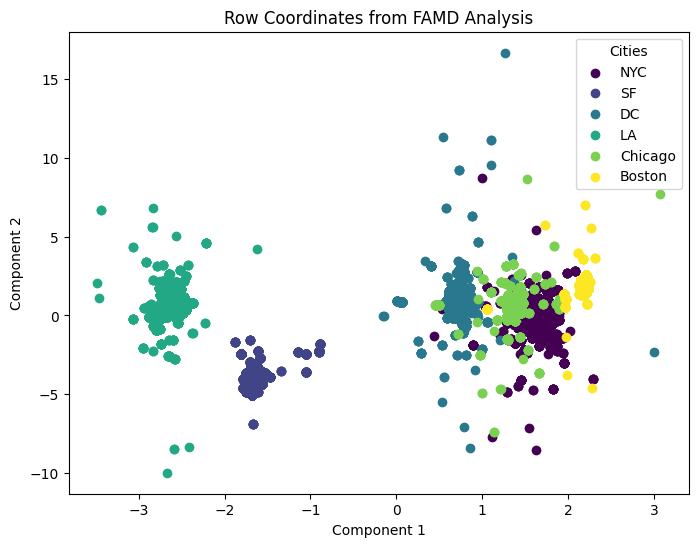

(74111, 3)


,location_component_0,location_component_1,city
id,,,
6901257,1.705783,-0.294103,NYC
6304928,1.660870,-0.234041,NYC
7919400,1.677362,-0.270865,NYC
13418779,-1.683706,-5.062434,SF
3808709,0.756076,0.332060,DC


In [554]:
df_locations  =  get_locations_features(df)
print(df_locations.shape)
df_locations.head()

In [400]:
df_locations.columns

Index(['location_component_0', 'location_component_1', 'city'], dtype='object')

In [504]:
df_datetime = cyclical_encode_dates(df)
print(df_datetime.shape)
df_datetime.head()

Missing rows in first_review: 15864
Missing rows in host_since: 188
Missing rows in last_review: 15827
(74111, 3)


/Users/ChanWingYiu/Documents/Data Science in the Wild/Project/dsw-project/feature_date.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ChanWingYiu/Documents/Data Science in the Wild/Project/dsw-project/feature_date.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ChanWingYiu/Documents/Data Science in the Wild/Project/dsw-project/feature_date.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

,first_review_days_since,host_since_days_since,last_review_days_since
id,,,
6901257,-0.353755,1.282186,1.166963e+00
6304928,-1.292354,-1.610406,-9.352288e-01
7919400,-1.071908,-1.251671,-8.914331e-01
13418779,0.000000,-0.411593,2.212884e-15
3808709,0.562118,-0.337424,2.521201e-01


In [541]:
all_data_df = pd.concat([
    df['log_price'],
    df_amenities_count,
    df_categorical[[
        'one_hot_encoder__room_type_Entire home/apt',
                    'one_hot_encoder__room_type_Private room',
                    'one_hot_encoder__room_type_Shared room', 
                    'one_hot_encoder__cleaning_fee_True',
                 'one_hot_encoder__instant_bookable_t']],
    df_nlp[['description_polarity', 'description_subjectivity']],
    df_numerical[['accommodates', 'beds_per_bedroom',
                  'bed_and_bathrooms']],
    df_locations[['location_component_0', 'location_component_1', 'city']],
    df_datetime
                         
                         ], axis=1)
print(all_data_df.shape)
all_data_df.head()

(74111, 18)


,log_price,amenities_count,one_hot_encoder__room_type_Entire home/apt,one_hot_encoder__room_type_Private room,one_hot_encoder__room_type_Shared room,one_hot_encoder__cleaning_fee_True,one_hot_encoder__instant_bookable_t,description_polarity,description_subjectivity,accommodates,beds_per_bedroom,bed_and_bathrooms,location_component_0,location_component_1,city,first_review_days_since,host_since_days_since,last_review_days_since
id,,,,,,,,,,,,,,,,,,
6901257,5.010635,-1.242623,True,False,False,True,False,0.750000,0.937500,3,0.500000,-0.389631,1.705783,-0.294103,NYC,-0.353755,1.282186,1.166963e+00
6304928,5.129899,-0.375379,True,False,False,True,True,0.297500,0.512083,7,0.750000,1.168598,1.660870,-0.234041,NYC,-1.292354,-1.610406,-9.352288e-01
7919400,4.976734,0.202783,True,False,False,True,True,0.274085,0.512857,5,1.500000,-0.389631,1.677362,-0.270865,NYC,-1.071908,-1.251671,-8.914331e-01
13418779,6.620073,-0.375379,True,False,False,True,False,0.301186,0.553205,4,0.666667,0.389484,-1.683706,-5.062434,SF,0.000000,-0.411593,2.212884e-15
3808709,4.744932,-0.809001,True,False,False,True,True,0.239881,0.495833,2,1.000000,-1.168745,0.756076,0.332060,DC,0.562118,-0.337424,2.521201e-01


In [542]:
print(all_data_df.dtypes)

log_price                                     float64
amenities_count                               float64
one_hot_encoder__room_type_Entire home/apt       bool
one_hot_encoder__room_type_Private room          bool
one_hot_encoder__room_type_Shared room           bool
one_hot_encoder__cleaning_fee_True               bool
one_hot_encoder__instant_bookable_t              bool
description_polarity                          float64
description_subjectivity                      float64
accommodates                                    int64
beds_per_bedroom                              float64
bed_and_bathrooms                             float64
location_component_0                          float64
location_component_1                          float64
city                                           object
first_review_days_since                       float64
host_since_days_since                         float64
last_review_days_since                        float64
dtype: object


In [543]:
all_data_df.columns[all_data_df.isna().any()].tolist()

[]

In [544]:
all_data_df.shape

(74111, 18)

In [545]:
X = all_data_df.drop(['log_price', 'city'], axis=1).copy()
X = X.apply(pd.to_numeric)
# Convert boolean columns to integers if there are any
for col in X.columns:
    if X[col].dtype == bool:
        X[col] = X[col].astype(int)

y = all_data_df['log_price'].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [546]:
model = LinearRegression()

In [547]:
model.fit(X_train, y_train)

LinearRegression()

In [548]:
# Make predictions using the testing set
y_pred = model.predict(X_test)

In [549]:
# The coefficients
# print('Coefficients:', model.coef_)

# Mean squared error
print('Mean squared error:', mean_squared_error(y_test, y_pred))

# Coefficient of determination (1 is perfect prediction)
print('Coefficient of determination:', r2_score(y_test, y_pred))

Mean squared error: 0.23625451422175625
Coefficient of determination: 0.5401156241230958


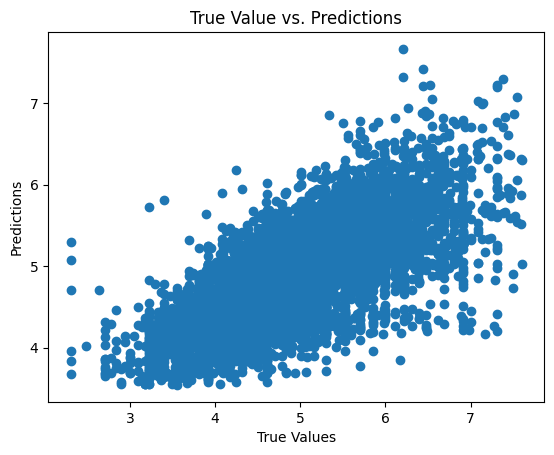

In [550]:
# Plotting for visualization
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Value vs. Predictions')
plt.show()

In [551]:
# Add a constant to the features for the intercept
X_with_const = sm.add_constant(X)

# Fit the model
model = sm.OLS(y,X_with_const).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     5461.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        17:42:13   Log-Likelihood:                -51679.
No. Observations:               74111   AIC:                         1.034e+05
Df Residuals:                   74094   BIC:                         1.035e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

# Fitting Linear Regression by City 

city:  Boston
Mean squared error: 0.18906014695839582
Coefficient of determination: 0.5787336532628411


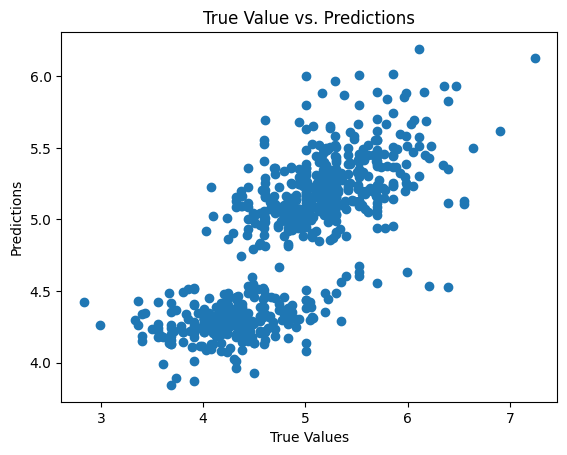

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     305.0
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        17:43:09   Log-Likelihood:                -2040.8
No. Observations:                3468   AIC:                             4114.
Df Residuals:                    3452   BIC:                             4212.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

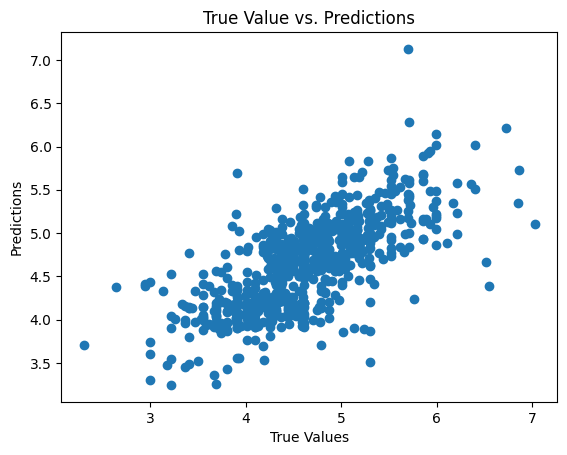

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     309.3
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        17:43:09   Log-Likelihood:                -2440.9
No. Observations:                3719   AIC:                             4914.
Df Residuals:                    3703   BIC:                             5013.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

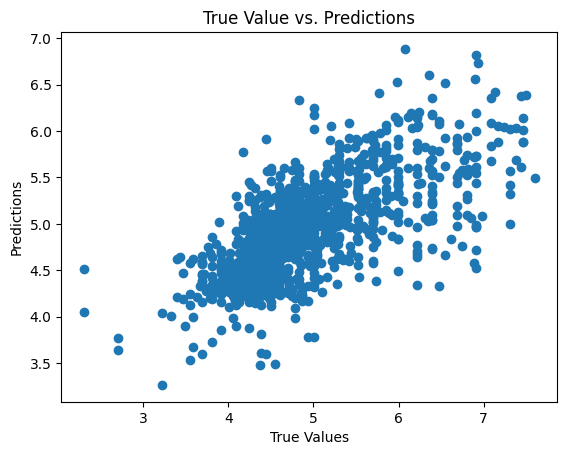

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     284.3
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        17:43:10   Log-Likelihood:                -5355.3
No. Observations:                5688   AIC:                         1.074e+04
Df Residuals:                    5672   BIC:                         1.085e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

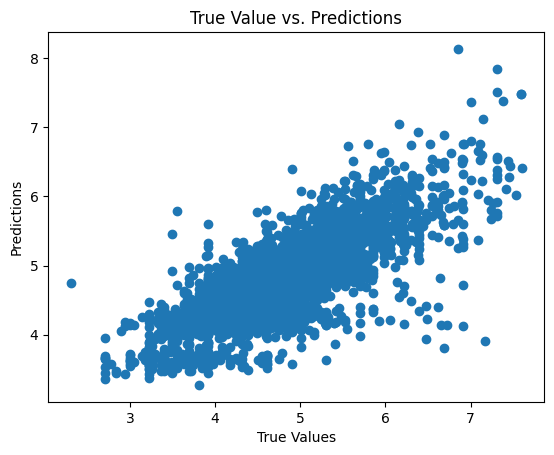

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     2448.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        17:43:11   Log-Likelihood:                -14193.
No. Observations:               22453   AIC:                         2.842e+04
Df Residuals:                   22437   BIC:                         2.855e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

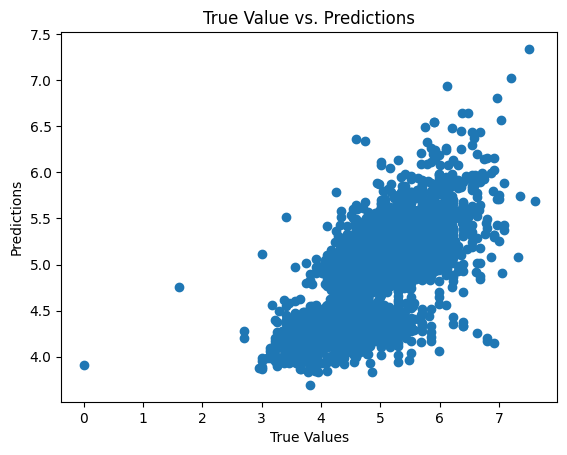

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     2314.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        17:43:12   Log-Likelihood:                -20740.
No. Observations:               32349   AIC:                         4.151e+04
Df Residuals:                   32333   BIC:                         4.165e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

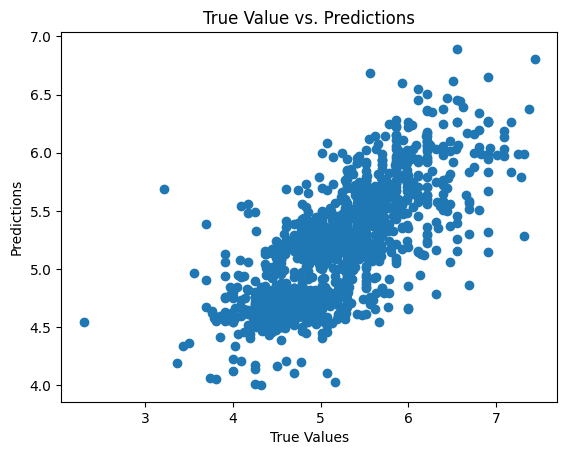

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     500.6
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        17:43:12   Log-Likelihood:                -4150.7
No. Observations:                6434   AIC:                             8333.
Df Residuals:                    6418   BIC:                             8442.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [552]:
for city in ['Boston', 'Chicago', 'DC', 'LA', 'NYC', 'SF']:
    print("city: ", city)
    city_df = all_data_df[all_data_df['city'] == city].reset_index(drop=True)
    X = city_df.copy()
    X.drop(['city', 'log_price'], axis=1, inplace=True)
    X = X.apply(pd.to_numeric)
    # Convert boolean columns to integers if there are any
    for col in X.columns:
        if X[col].dtype == bool:
            X[col] = X[col].astype(int)
    y = city_df['log_price']

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Mean squared error
    print('Mean squared error:', mean_squared_error(y_test, y_pred))

    # Coefficient of determination (1 is perfect prediction)
    print('Coefficient of determination:', r2_score(y_test, y_pred))
    # Plotting for visualization
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True Value vs. Predictions')
    plt.show()
    # Add a constant to the features for the intercept
    X_with_const = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X_with_const).fit()

    # Print the summary
    print(model.summary())